# 回归-基础学习器：最佳模型
只对7天付费数据进行回归
## 去掉训练集大比例特征
- 4 正则化的线性回归 ElasticNetCV
- 5 Gradient Boosting Regressor
- 6 RandomForestRegressor
- 7 BaggingRegressor

In [1]:
# 导入必要的工具包
import numpy as np #用于数值计算
import pandas as pd #用于数据表处理，数据文件读写
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn import ensemble

import matplotlib.pyplot as plt #用于绘图：分析结果的可视化。
#应该是设置浮点数的形式格式，小数点后三位
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#这一行是干嘛的？ 设置 matplotlib 让绘制的图形出现在 Notebook 里而不是新窗口
%matplotlib inline

In [2]:
def get_train_val(val_id):
    '''获取训练集和校验集 
    val_id = 0,1,2 #当前校验集编号 '''
    print('val_id=%s'% (val_id))
    df_val = train_list[val_id]
    train_tmp = []

    for i in range(1, train_part_num):
        cur_id = (val_id + i) % 5
        print('cur_id=%s'% (cur_id))
        train_tmp.append(train_list[cur_id])
    
#     只生成一次，节省内存 
    df_train = pd.concat(train_tmp)
    print('df_train.shape=%s  df_val.shape=%s'% (df_train.shape, df_val.shape))
    return df_train, df_val

In [3]:
train_part_num = 5 #训练集拆分个数
Y_Standard = True
path_train = '../../data/new/train=all-class/'
path_test = '../../data/new/test/'

val_path = '../../data/val/7partBase/' #保存校验集测试结果
val_name = '%sval=stacking-%s-%s=%s.csv'
summit_path = '../../data/summit/7partBase/' #保存提交文件，测试集测试结果 
part_name = '7pay' #拆分的部分
predict_name = '%s%s=stacking-%s-%s.csv' # 生成的结果文件名称：只有当前部分
out_name = '%ssummit=stacking-%s-%s=%s.csv' # 生成的结果文件名称：用于提交
base = '7partBase' #学习器级别 

target = 'prediction_pay_price'
user_id = 'user_id'

## 指定读取数据类型，节省内存

In [4]:
col_int32 = ['user_id', 'register_time', 'wood_add_value', 'wood_reduce_value',
       'stone_add_value', 'stone_reduce_value', 'ivory_add_value',
       'ivory_reduce_value', 'meat_add_value', 'meat_reduce_value',
       'magic_add_value', 'magic_reduce_value', 'infantry_add_value',
       'infantry_reduce_value', 'cavalry_add_value', 'cavalry_reduce_value',
       'shaman_add_value', 'shaman_reduce_value', 'wound_infantry_add_value',
       'wound_infantry_reduce_value', 'wound_cavalry_add_value',
       'wound_cavalry_reduce_value', 'wound_shaman_add_value',
       'wound_shaman_reduce_value', 'general_acceleration_add_value',
       'general_acceleration_reduce_value', 'building_acceleration_add_value',
       'building_acceleration_reduce_value', 'reaserch_acceleration_add_value',
       'reaserch_acceleration_reduce_value', 'training_acceleration_add_value',
       'training_acceleration_reduce_value', 'treatment_acceleraion_add_value',
       'treatment_acceleration_reduce_value', 'bd_training_hut_level',
       'bd_healing_lodge_level', 'bd_stronghold_level',
       'bd_outpost_portal_level', 'bd_barrack_level',
       'bd_healing_spring_level', 'bd_dolmen_level', 'bd_guest_cavern_level',
       'bd_warehouse_level', 'bd_watchtower_level', 'bd_magic_coin_tree_level',
       'bd_hall_of_war_level', 'bd_market_level', 'bd_hero_gacha_level',
       'bd_hero_strengthen_level', 'bd_hero_pve_level', 'sr_scout_level', 
       'sr_training_speed_level', 'sr_infantry_tier_2_level',
       'sr_cavalry_tier_2_level', 'sr_shaman_tier_2_level',
       'sr_infantry_atk_level', 'sr_cavalry_atk_level', 'sr_shaman_atk_level',
       'sr_infantry_tier_3_level', 'sr_cavalry_tier_3_level',
       'sr_shaman_tier_3_level', 'sr_troop_defense_level',
       'sr_infantry_def_level', 'sr_cavalry_def_level', 'sr_shaman_def_level',
       'sr_infantry_hp_level', 'sr_cavalry_hp_level', 'sr_shaman_hp_level',
       'sr_infantry_tier_4_level', 'sr_cavalry_tier_4_level',
       'sr_shaman_tier_4_level', 'sr_troop_attack_level',
       'sr_construction_speed_level', 'sr_hide_storage_level',
       'sr_troop_consumption_level', 'sr_rss_a_prod_levell',
       'sr_rss_b_prod_level', 'sr_rss_c_prod_level', 'sr_rss_d_prod_level',
       'sr_rss_a_gather_level', 'sr_rss_b_gather_level',
       'sr_rss_c_gather_level', 'sr_rss_d_gather_level', 'sr_troop_load_level',
       'sr_rss_e_gather_level', 'sr_rss_e_prod_level',
       'sr_outpost_durability_level', 'sr_outpost_tier_2_level',
       'sr_healing_space_level', 'sr_gathering_hunter_buff_level',
       'sr_healing_speed_level', 'sr_outpost_tier_3_level',
       'sr_alliance_march_speed_level', 'sr_pvp_march_speed_level',
       'sr_gathering_march_speed_level', 'sr_outpost_tier_4_level',
       'sr_guest_troop_capacity_level', 'sr_march_size_level',
       'sr_rss_help_bonus_level', 'pvp_battle_count', 'pvp_lanch_count',
       'pvp_win_count', 'pve_battle_count', 'pve_lanch_count', 'pve_win_count',
       'pay_count']
col_float32 = ['avg_online_minutes', 'pay_price']

In [5]:
# 指定读取数据类型，节省内存
dtype_test = {}
for col in col_int32:
    dtype_test[col] = np.int32
for col in col_float32:
    dtype_test[col] = np.float32
# dtype_test

In [6]:
dtype_train = dtype_test.copy()
dtype_train[target] = np.float32
# dtype_train

## 读取数据，一次读取多次使用，不同组合 

In [7]:
train_list = []
for i in range(train_part_num):
    cur_id = i + 1
    train_list.append(pd.read_csv('%strain_7pay-%s.csv' % (path_train, cur_id), dtype=dtype_train))
train_list[0].head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,105707,132,8397383,6427675,5770426,4400596,1682169,61952,9504239,5348066,...,1,0,1,95,95,91,134.0000,1.9800,2,1.9800
1,3068935,126,1063632,1010687,250000,0,3000,0,768284,666081,...,6,0,0,2,2,2,10.1667,4.9900,1,4.9900
2,1094283,110,6607384,6704369,2317467,2418199,673855,134847,7045820,5959153,...,3,0,2,97,97,95,120.5000,11.9700,3,11.9700
3,1917810,102,1162703,825989,0,0,3000,0,1241964,662573,...,3,0,2,14,14,10,45.5000,0.9900,1,0.9900
4,2575551,115,8778561,8697048,2044201,2060980,810000,0,8892722,9517415,...,22,8,9,36,36,27,129.6667,2.9800,2,2.9800


## 5折交叉验证

In [8]:
# 根据校验集编号 0，1,2,3,4 ，获取训练集和校验集
df_train, df_val = get_train_val(0)

# # 剔除离群点: 效果不好 
# outlier = 30000
# df_train = df_train[df_train[target] < outlier]
# df_val = df_val[df_val[target] < outlier]

val_id=0
cur_id=1
cur_id=2
cur_id=3
cur_id=4
df_train.shape=(33151, 109)  df_val.shape=(8288, 109)


Text(0.5,1,'Distribution of prediction_pay_price')

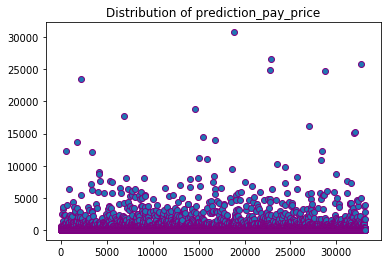

In [9]:
# 离群点检测：单个特征散点图
plt.scatter(range(df_train.shape[0]), df_train[target].values, edgecolors='purple')
plt.title('Distribution of prediction_pay_price')
# 超过 25000 可以认为是异常点

In [10]:
# # 剔除离群点：删除 y 大于 700000 的样本
# df_train = df_train[df_train[target] < 20000]
# df_train.shape

In [11]:
# # 离群点检测：单个特征散点图
# plt.scatter(range(df_val.shape[0]), df_val[target].values, edgecolors='purple')
# plt.title('Distribution of prediction_pay_price')
# # 超过 25000 可以认为是异常点

In [12]:
# # 剔除离群点：删除 y 大于 700000 的样本
# df_val = df_val[df_val[target] < 20000]
# df_val.shape

In [13]:
# 从原始数据中分离输入特征x和输出y
train_y = df_train[target].values
train_X = df_train.drop([target, user_id], axis = 1)
val_y = df_val[target].values
val_X = df_val.drop([target, user_id], axis = 1)

In [14]:
# 数据标准化：分别初始化对特征和目标值的标准化器 
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
train_X_ss = ss_X.fit_transform(train_X)
val_X_ss = ss_X.transform(val_X)

if Y_Standard:
    train_y_ss = ss_y.fit_transform(train_y.reshape(-1, 1))
    val_y_ss = ss_y.transform(val_y.reshape(-1, 1))
    # 需要转换为一维数组 
    train_y_ss_1d = train_y_ss.reshape(train_y_ss.shape[0])
    val_y_ss_1d = val_y_ss.reshape(val_y_ss.shape[0])
else:
    # 需要转换为一维数组 
    train_y_ss_1d = train_y.reshape(train_y.shape[0])
    val_y_ss_1d = val_y.reshape(val_y.shape[0])

In [130]:
def inverse_StandardScaler(predict):
    ''' 标准化数据还原  '''
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

def generate_summit(predict, df, isTest=False, modelName=''):
    ''' 输出预测后的数据 '''
    testPredict = df.copy()
    testPredict[target] = predict * (118/88)
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
#     过滤掉太大的数值看看
#     testPredict[target] = testPredict[target].apply(lambda x: x if x < 20000 else 20000)
    if isTest: #测试集需要合并其他部分 
        testPredict_7nopay = pd.read_csv(summit_path + 'summit=stacking-7partBase-%s=7nopay.csv' % modelName, dtype=dtype_test)
#         testPredict_7nopay[target] = 0
        testPredict = pd.concat([testPredict, testPredict_7nopay])
    return testPredict

## 模型训练
###  4. 正则化的线性回归 ElasticNetCV

In [124]:
%%time
# l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
l1_ratio = [.99, 1]

# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.0001)
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.0005)
model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.001) #效果最好
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.005)
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.01)
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.05)
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.1)
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.2)
model.fit(train_X_ss, train_y_ss_1d)
print ('best alpha is:%s  l1_ratio_:%s' % (model.alpha_, model.l1_ratio_))
# best alpha is:0.01521175269129301  l1_ratio_:0.5
# Wall time: 3min 3s

best alpha is:0.057946660227507656  l1_ratio_:1.0
Wall time: 1.98 s


In [125]:
# 模型评估
scoreTrain = model.score(train_X_ss, train_y_ss_1d)
scoreVal = model.score(val_X_ss, val_y_ss_1d)
print('The score of model: Train=%s  Val=%s'% (scoreTrain, scoreVal)) 

predict_train = model.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, predict_train) ** 0.5
predict_val = model.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score of model: Train=0.5124631116286654  Val=0.6303096358339539
# The RMSE: Train=0.6982383778762523  Val=0.7075137920557196

The score of model: Train=0.5124631116286654  Val=0.6303096358339539
The RMSE: Train=0.6982383778762523  Val=0.7075137920557196


### 保存校验集测试结果

In [33]:
print('predict_val= ', predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(predict_val)
valPredict = generate_summit(predict_val, df_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'ElasticNetCV', part_name), index=False)
valPredict.head()

predict_val=  [-0.11380756 -0.12650728 -0.07256617 ... -0.13495313 -0.08362833
  0.31056741]
predict =  [ 22.20945278  14.28543387  47.94210434 ...   9.01562752  41.039849
 286.99910346]


,user_id,prediction_pay_price
0,105707,22.2095
1,3068935,14.2854
2,1094283,47.9421
3,1917810,5.2161
4,2575551,24.7862


## 加载测试数据

In [126]:
test = pd.read_csv(path_test + 'test-7pay.csv', dtype=dtype_test)
test_X = test.drop([user_id], axis = 1)
test_X_ss = ss_X.transform(test_X)
test.head()

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,sr_rss_help_bonus_level,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count
0,14952,94,3838322,2859288,1041000,0,504000,0,6898146,4297996,...,0,4,4,4,4,4,3,27.1667,0.9900,1
1,15029,94,2353190,1286349,1000000,0,609000,0,3216753,513123,...,0,2,0,0,5,5,5,19.5000,0.9900,1
2,15059,94,6058137,3960541,5040000,2520000,2109000,0,14586512,7910807,...,0,0,0,0,11,11,9,13.8333,5.9800,2
3,15064,94,2958155,2350347,1364518,407296,600000,0,5895581,3241016,...,0,2,1,0,2,2,2,13.0000,0.9900,1
4,15102,94,1080008,19659,1000000,0,500000,0,2303911,13076,...,0,0,0,0,1,1,1,2.1667,0.9900,1


In [127]:
#对测试数据进行预测
model_y_predict_test = model.predict(test_X_ss)
print('model_y_predict_test = ', model_y_predict_test)

# 标准化数据还原 
y_predict_test = inverse_StandardScaler(model_y_predict_test)
# lasso_y_predict_test =  [0.4556051 0.4556051 0.4556051 ... 0.4556051 0.4556051 0.4556051]

model_y_predict_test =  [-0.13429564 -0.1382523  -0.10090096 ... -0.09987682 -0.13904867
 -0.12796744]
predict =  [ 9.4258728   6.95710809 30.26255199 ... 30.90156817  6.46020842
 13.37436463]


In [128]:
#输出预测后的数据：不组合其他部分
testPredict = generate_summit(y_predict_test, test)
testPredict.to_csv(predict_name %(summit_path, part_name, base, 'ElasticNetCV'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14952,7.0295
1,15029,5.1884
2,15059,22.5687
3,15064,6.1527
4,15102,4.0177


In [131]:
#输出预测后的数据：组合了其他部分
testPredict = generate_summit(y_predict_test, test, True, 'ElasticNetCV')
testPredict.to_csv(out_name %(summit_path, base, 'ElasticNetCV', part_name), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14952,12.6392
1,15029,9.3288
2,15059,40.5793
3,15064,11.0627
4,15102,7.2240


## 5 GradientBoostingRegressor

In [112]:
%%time
model = ensemble.GradientBoostingRegressor(learning_rate=0.239, n_estimators=17, min_samples_split=90, min_samples_leaf=10, alpha=0.99)
model.fit(train_X_ss, train_y_ss_1d)
# Wall time: 3min 2s 

Wall time: 1.94 s


In [113]:
# 模型评估
scoreTrain = model.score(train_X_ss, train_y_ss_1d)
scoreVal = model.score(val_X_ss, val_y_ss_1d)
print('The score: Train=%s  Val=%s'% (scoreTrain, scoreVal)) 

model_predict_train = model.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, model_predict_train) ** 0.5
model_predict_val = model.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, model_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# learning_rate=0.25, n_estimators=14, min_samples_split=80, min_samples_leaf=8, alpha=0.99
# learning_rate=0.25, n_estimators=16, min_samples_split=80, min_samples_leaf=8, alpha=0.99
# learning_rate=0.25, n_estimators=16, min_samples_split=80, min_samples_leaf=10, alpha=0.99
# learning_rate=0.239, n_estimators=17, min_samples_split=90, min_samples_leaf=10, alpha=0.99
# The score: Train=0.6432610234173325  Val=0.5699190808858694
# The RMSE: Train=0.5972762640378839  Val=0.7631166554119698

The score: Train=0.6432610234173326  Val=0.5699190808858695
The RMSE: Train=0.5972762640378839  Val=0.7631166554119697


### 保存校验集测试结果

In [115]:
print('model_predict_val= ', model_predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(model_predict_val)
valPredict = generate_summit(predict_val, df_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'GradientBoostingRegressor', part_name), index=False)
valPredict.head()

model_predict_val=  [-0.11029683 -0.11029683 -0.11029683 ... -0.11029683 -0.11029683
  0.28418707]
predict =  [ 24.39998276  24.39998276  24.39998276 ...  24.39998276  24.39998276
 270.53903219]


,user_id,prediction_pay_price
0,105707,24.4000
1,3068935,24.4000
2,1094283,24.4000
3,1917810,24.4000
4,2575551,24.4000


In [116]:
#对测试数据进行预测
model_y_predict_test = model.predict(test_X_ss)
print('model_y_predict_test = ', model_y_predict_test)

# 标准化数据还原 
y_predict_test = inverse_StandardScaler(model_y_predict_test)

model_y_predict_test =  [-0.11029683 -0.11029683 -0.11029683 ... -0.11029683 -0.11029683
 -0.11029683]
predict =  [24.39998276 24.39998276 24.39998276 ... 24.39998276 24.39998276
 24.39998276]


In [117]:
#输出预测后的数据：不组合其他部分
testPredict = generate_summit(y_predict_test, test)
testPredict.to_csv(predict_name %(summit_path, part_name, base, 'GradientBoostingRegressor'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14952,24.4000
1,15029,24.4000
2,15059,24.4000
3,15064,24.4000
4,15102,24.4000


In [120]:
#输出预测后的数据：组合了其他部分
testPredict = generate_summit(y_predict_test, test, True, 'ElasticNetCV')
testPredict.to_csv(out_name %(summit_path, base, 'GradientBoostingRegressor', part_name), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14952,24.4000
1,15029,24.4000
2,15059,24.4000
3,15064,24.4000
4,15102,24.4000


## 6 RandomForestRegressor

In [22]:
%%time
model = ensemble.RandomForestRegressor(n_estimators=16, min_samples_split=80, min_samples_leaf=8, n_jobs=-1)
model.fit(train_X_ss, train_y_ss_1d)
# Wall time: 10min 2s 

Wall time: 6.97 s


In [23]:
# 模型评估
scoreTrain = model.score(train_X_ss, train_y_ss_1d)
scoreVal = model.score(val_X_ss, val_y_ss_1d)
print('The score: Train=%s  Val=%s'% (scoreTrain, scoreVal)) 

model_predict_train = model.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, model_predict_train) ** 0.5
model_predict_val = model.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, model_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# n_estimators=14, min_samples_split=80, min_samples_leaf=8, min_impurity_decrease=0.1
# n_estimators=20, min_samples_split=80, min_samples_leaf=8, min_impurity_decrease=0.1
# n_estimators=20, min_samples_split=80, min_samples_leaf=8, min_impurity_decrease=0.0
# n_estimators=20, min_samples_split=100, min_samples_leaf=8
# n_estimators=16, min_samples_split=100, min_samples_leaf=8
# The score: Train=0.6193906706679225  Val=0.4333588747424302
# The RMSE: Train=0.6169354557150862  Val=0.8718379844283086 
# n_estimators=16, min_samples_split=80, min_samples_leaf=8
# The score: Train=0.6393206199636329  Val=0.35457588882649244
# The RMSE: Train=0.6005657993266247  Val=0.517339714712821

The score: Train=0.583956589556768  Val=0.49581719925796
The RMSE: Train=0.6450142538876716  Val=0.8774750957561084


### 保存校验集测试结果

In [24]:
print('model_predict_val= ', model_predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(model_predict_val)
valPredict = generate_summit(predict_val, df_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'RandomForestRegressor'), index=False)
valPredict.head()

model_predict_val=  [-0.1445315   1.69831279  0.32877925 ... -0.12928703 -0.0603818
 -0.1399901 ]
predict =  [   2.36816721 1085.0178158   280.43274633 ...   11.32411764   51.80514071
    5.03618722]


,user_id,prediction_pay_price
0,563914,2.3682
1,1837494,1085.0178
2,1775165,280.4327
3,3038897,2.2484
4,285815,6.0593


In [25]:
#对测试数据进行预测
model_y_predict_test = model.predict(test_X_ss)
print('model_y_predict_test = ', model_y_predict_test)

# 标准化数据还原 
y_predict_test = inverse_StandardScaler(model_y_predict_test)

model_y_predict_test =  [-0.08238434 -0.07292834 -0.06258769 ... -0.02516248 -0.0492921
 -0.05108797]
predict =  [38.87890181 44.43419366 50.50920791 ... 72.49608479 58.32020776
 57.2651576 ]


In [26]:
# ridge_y_predict_test = move_up(ridge_y_predict_test)
#输出预测后的数据
testPredict = generate_summit(y_predict_test, test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'RandomForestRegressor'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,38.8789
1,14934,44.4342
2,14935,50.5092
3,14936,39.3197
4,14937,53.4540


## 7 BaggingRegressor

In [27]:
%%time
model = ensemble.BaggingRegressor(n_jobs=2, n_estimators=20)
model.fit(train_X_ss, train_y_ss_1d)
# Wall time: 9min 2s 

Wall time: 24.3 s


In [28]:
%%time
# 模型评估
scoreTrain = model.score(train_X_ss, train_y_ss_1d)
scoreVal = model.score(val_X_ss, val_y_ss_1d)
print('The score: Train=%s  Val=%s'% (scoreTrain, scoreVal)) 

model_predict_train = model.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, model_predict_train) ** 0.5
model_predict_val = model.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, model_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# n_estimators=10 
# n_estimators=15 
# he score: Train=0.944126770370558  Val=0.35667035830687766
# The RMSE: Train=0.2363752321974746  Val=0.5473401373069637
# n_estimators=20 


The score: Train=0.9084004210793603  Val=0.5113913103519558
The RMSE: Train=0.30265421509921697  Val=0.8638162690790285
Wall time: 4.5 s


### 保存校验集测试结果

In [29]:
print('model_predict_val= ', model_predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(model_predict_val)
valPredict = generate_summit(predict_val, df_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'BaggingRegressor'), index=False)
valPredict.head()

model_predict_val=  [-0.14500466  2.11534174  0.15957826 ... -0.12965373 -0.01657653
 -0.13261034]
predict =  [   2.09019103 1330.0174898   181.02912418 ...   11.10868509   77.54022964
    9.37170776]


,user_id,prediction_pay_price
0,563914,2.0902
1,1837494,1330.0175
2,1775165,181.0291
3,3038897,2.7386
4,285815,13.0659


In [30]:
#对测试数据进行预测
model_y_predict_test = model.predict(test_X_ss)
print('model_y_predict_test = ', model_y_predict_test)

# 标准化数据还原 
y_predict_test = inverse_StandardScaler(model_y_predict_test)

model_y_predict_test =  [-0.13710695 -0.13593721  0.04477152 ... -0.07671938 -0.09576869
 -0.1072685 ]
predict =  [  6.73000233   7.41721569 113.58149923 ...  42.20699965  31.01575206
  24.2597502 ]


In [31]:
# ridge_y_predict_test = move_up(ridge_y_predict_test)
#输出预测后的数据
testPredict = generate_summit(y_predict_test, test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'BaggingRegressor'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,6.7300
1,14934,7.4172
2,14935,113.5815
3,14936,23.5250
4,14937,122.9885


## 7-1 BaggingRegressor的代码最佳示例
https://www.helplib.com/Python-Module-Examples/article_66154